# AI-generated Fed Statements - Data scraping, cleaning & EDA

## Dependencies

In [2]:
import pandas as pd
import pickle
from scraper import FOMC
import re
from datetime import date
from collections import Counter

from yellowbrick.text import DispersionPlot
import matplotlib.pyplot as plt

import spacy
# only run line 9 if language model has not been pre-installed
# !python -m spacy download en_core_web_md
spacy_nlp = spacy.load('en_core_web_md')
from spacy.lang.en.stop_words import STOP_WORDS

## Scraping

In [3]:
# run scraper
fed = FOMC()
df = fed.get_statements()

Getting links...
There are 169 statements
Getting articles - Multi-threaded...
.........................................................................................................................................................................

In [8]:
# load from pickled file
# f = open('data/FOMC.pkl', 'rb')
# df = pickle.load(f)
# f.close()

## Quick look at the data
Checking a 1998 and a 2018 Fed statement to see how much cleaning and wrangling we will have to do

In [4]:
len(df)

169

In [5]:
pd.set_option('display.max_colwidth', -1)

In [6]:
df['1998-09-01':'1998-10-01']

,statements
1998-09-29,"For immediate release\n\n\n\n\n\n\r\nThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/4 percent.\r\n\r\n\tThe action was taken to cushion the effects on prospective economic growth in the United States of increasing weakness in foreign economies and of less accommodative financial conditions domestically. The recent changes in the global economy and adjustments in U.S. financial markets mean that a slightly lower federal funds rate should now be consistent with keeping inflation low and sustaining economic growth going forward.\r\n\r\n\tThe discount rate remains unchanged at 5 percent.\n\nFor immediate release\n\n\n\n\n\n\r\nThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/4 percent.\r\n\r\n\tThe action was taken to cushion the effects on prospective economic growth in the United States of increasing weakness in foreign economies and of less accommodative financial conditions domestically. The recent changes in the global economy and adjustments in U.S. financial markets mean that a slightly lower federal funds rate should now be consistent with keeping inflation low and sustaining economic growth going forward.\r\n\r\n\tThe discount rate remains unchanged at 5 percent.\n\nThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/4 percent.\r\n\r\n\tThe action was taken to cushion the effects on prospective economic growth in the United States of increasing weakness in foreign economies and of less accommodative financial conditions domestically. The recent changes in the global economy and adjustments in U.S. financial markets mean that a slightly lower federal funds rate should now be consistent with keeping inflation low and sustaining economic growth going forward.\r\n\r\n\tThe discount rate remains unchanged at 5 percent.\n\nThe action was taken to cushion the effects on prospective economic growth in the United States of increasing weakness in foreign economies and of less accommodative financial conditions domestically. The recent changes in the global economy and adjustments in U.S. financial markets mean that a slightly lower federal funds rate should now be consistent with keeping inflation low and sustaining economic growth going forward.\r\n\r\n\tThe discount rate remains unchanged at 5 percent.\n\nThe discount rate remains unchanged at 5 percent.\n\n1998 Monetary policy\n\n Home | News and events\nAccessibility\n\nLast update: September 29, 1998, 2:15 PM"


In [7]:
df['2018-09-01':'2018-10-01']

,statements
2018-09-26,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\nFederal Open Market Committee\n\nMonetary Policy Principles and Practice\n\nPolicy Implementation\n\nReports\n\nReview of Monetary Policy Strategy, Tools, and Communications\n\nInstitution Supervision\n\nReports\n\nReporting Forms\n\nSupervision & Regulation Letters\n\nBanking Applications & Legal Developments\n\nRegulatory Resources\n\nBanking & Data Structure\n\nRegulations & Statutes\n\nPayment Policies\n\nReserve Bank Payment Services & Data\n\nFinancial Market Utilities & Infrastructures\n\nResearch, Committees, and Forums\n\nWorking Papers and Notes\n\nModels and Tools\n\nBank Assets and Liabilities\n\nBank Structure Data\n\nBusiness Finance\n\nDealer Financing Terms\n\nExchange Rates and International Data\n\nFinancial Accounts\n\nHousehold Finance\n\nIndustrial Activity\n\nInterest Rates\n\nMicro Data Reference Manual (MDRM)\n\nMoney Stock and Reserve Balances\n\nRegulations\n\nSupervision & Enforcement\n\nCommunity Development\n\nResearch & Analysis\n\nConsumer Resources\n\nSeptember 26, 2018\n\nFor release at 2:00 p.m. EDT \n \n \n\nShare\n\nInformation received since the Federal Open Market Committee met in August indicates that the labor market has continued to strengthen and that economic activity has been rising at a strong rate. Job gains have been strong, on average, in recent months, and the unemployment rate has stayed low. Household spending and business fixed investment have grown strongly. On a 12-month basis, both overall inflation and inflation for items other than food and energy remain near 2 percent. Indicators of longer-term inflation expectations are little changed, on balance.\n\nConsistent with its statutory mandate, the Committee seeks to foster maximum employment and price stability. The Committee expects that further gradual increases in the target range for the federal funds rate will be consistent with sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective over the medium term. Risks to the economic outlook appear roughly balanced.\n\nIn view of realized and expected labor market conditions and inflation, the Committee decided to raise the target range for the federal funds rate to 2 to 2-1/4 percent.\n\nIn determining the timing and size of future adjustments to the target range for the federal funds rate, the Committee will assess realized and expected economic conditions relative to its maximum employment objective and its symmetric 2 percent inflation objective. This assessment will take into account a wide range of information, including measures of labor market conditions, indicators of inflation pressures and inflation expectations, and readings on financial and international developments.\n\nVoting for the FOMC monetary policy action were: Jerome H. Powell, Chairman; John C. Williams, Vice Chairman; Thomas I. Barkin; Raphael W. Bostic; Lael Brainard; Richard H. Clarida; Esther L. George; Loretta J. Mester; and Randal K. Quarles.\n\nImplementation Note issued September 26, 2018\n\nBoard of Governors of the Federal Reserve System\n\n20th Street and Constitution Avenue N.W., Washington, DC 20551"


## Cleaning the data

In [9]:
# remove line breaks
df['statements'].replace(r'\s+|\\n', ' ', regex=True, inplace=True) 

# removes superfluous year dates
df['statements'] = df['statements'].str.replace('\. \d{4}', '. ', \
            flags=re.IGNORECASE) 

def regex_clean(term_list):
    """Cutting irrelevant phrases"""
    for term in term_list:
        df['statements'] = df['statements'].str.replace(term, ' ', flags=re.IGNORECASE)

# list of regex terms to find phrases to be deleted
regex_terms = ['^(.*Share)', '^(.*For immediate release)', \
               '(Voting for the FOMC monetary policy action were:).*',\
               '(Voting for the monetary policy action were).*',\
               '(Monetary policy Home).*', '(Monetary policy Last update).*']

regex_clean(regex_terms)

In [10]:
df["1998-09-01":"1998-10-10"]

,statements
1998-09-29,"The Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/4 percent. The action was taken to cushion the effects on prospective economic growth in the United States of increasing weakness in foreign economies and of less accommodative financial conditions domestically. The recent changes in the global economy and adjustments in U.S. financial markets mean that a slightly lower federal funds rate should now be consistent with keeping inflation low and sustaining economic growth going forward. The discount rate remains unchanged at 5 percent. The Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/4 percent. The action was taken to cushion the effects on prospective economic growth in the United States of increasing weakness in foreign economies and of less accommodative financial conditions domestically. The recent changes in the global economy and adjustments in U.S. financial markets mean that a slightly lower federal funds rate should now be consistent with keeping inflation low and sustaining economic growth going forward. The discount rate remains unchanged at 5 percent. The action was taken to cushion the effects on prospective economic growth in the United States of increasing weakness in foreign economies and of less accommodative financial conditions domestically. The recent changes in the global economy and adjustments in U.S. financial markets mean that a slightly lower federal funds rate should now be consistent with keeping inflation low and sustaining economic growth going forward. The discount rate remains unchanged at 5 percent. The discount rate remains unchanged at 5 percent."


In [11]:
df['2018-09-01':'2018-10-01']

,statements
2018-09-26,"Information received since the Federal Open Market Committee met in August indicates that the labor market has continued to strengthen and that economic activity has been rising at a strong rate. Job gains have been strong, on average, in recent months, and the unemployment rate has stayed low. Household spending and business fixed investment have grown strongly. On a 12-month basis, both overall inflation and inflation for items other than food and energy remain near 2 percent. Indicators of longer-term inflation expectations are little changed, on balance. Consistent with its statutory mandate, the Committee seeks to foster maximum employment and price stability. The Committee expects that further gradual increases in the target range for the federal funds rate will be consistent with sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective over the medium term. Risks to the economic outlook appear roughly balanced. In view of realized and expected labor market conditions and inflation, the Committee decided to raise the target range for the federal funds rate to 2 to 2-1/4 percent. In determining the timing and size of future adjustments to the target range for the federal funds rate, the Committee will assess realized and expected economic conditions relative to its maximum employment objective and its symmetric 2 percent inflation objective. This assessment will take into account a wide range of information, including measures of labor market conditions, indicators of inflation pressures and inflation expectations, and readings on financial and international developments."


In [12]:
#pickle dataframe
f = open('data/FOMC_cleaned.pkl', 'wb')
pickle.dump(df, f)
f.close()

## Save file for fine-tuning AI model

In [17]:
tfile = open('data/text_clean.txt', 'a')
tfile.write(df.statements.str.cat(sep='   '))
tfile.close()

## Some further EDA

In [18]:
word_count_total = df.statements.str.split().str.len().sum()
article_count = df.shape[0]
article_word_average =  word_count_total / article_count

print("Total word count: ", format(word_count_total, ','))
print("Total article count: ", format(article_count, ','))
print()
print("Average number of words per article: ", format(int(article_word_average), ','))

Total word count:  62,820
Total article count:  169

Average number of words per article:  371


In [19]:
df['totalwords'] = df['statements'].str.split().str.len()

In [20]:
pd.set_option('display.max_colwidth', 100)
df.tail()

,statements,totalwords
2018-12-19,Information received since the Federal Open Market Committee met in November indicates that th...,289
2019-01-30,Information received since the Federal Open Market Committee met in December indicates that th...,287
2019-03-20,Information received since the Federal Open Market Committee met in January indicates that the...,303
2019-05-01,Information received since the Federal Open Market Committee met in March indicates that the l...,279
2019-06-19,Information received since the Federal Open Market Committee met in May indicates that the lab...,293


In [21]:
# to apply NER to all articles, we concatenate all rows of the dataframe
whole = spacy_nlp(df.statements.str.cat(sep=' '))

In [22]:
# apply lemmatisation + stopword removal to all words; show the most frequest of those
words = [token.lemma_ for token in whole.doc if token.is_stop != True and token.is_punct != True]
Counter(words).most_common(15)

[('Committee', 1237),
 ('inflation', 931),
 ('rate', 776),
 ('economic', 746),
 ('market', 544),
 ('Federal', 516),
 ('condition', 461),
 ('percent', 458),
 ('continue', 440),
 ('price', 438),
 ('growth', 432),
 ('remain', 400),
 ('federal', 392),
 ('fund', 385),
 ('policy', 366)]

Interestingly the second most important word is "inflation". The Fed's mandate is two-fold: maximum sustainable employment and price stability. So inflation, which is related to price stability, is a more common word here than employment. With 916 to 169 occurrences, inflation is mentioned 5.4 times more often than employment. 

/Users/marceldietsch/Documents/backtesting/venv/lib/python3.6/site-packages/yellowbrick/text/dispersion.py:163: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_target = np.stack(self._compute_dispersion(X, y))
/Users/marceldietsch/Documents/backtesting/venv/lib/python3.6/site-packages/yellowbrick/text/dispersion.py:169: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_target[:,1].astype(int)))
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB o

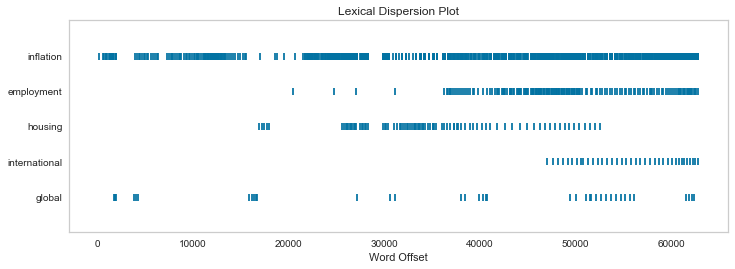

In [23]:
# Load the text data
df_dispersion = df.statements
df_dispersion = df_dispersion.T.squeeze()

# Create a list of words from the corpus text
text = [doc.split() for doc in df_dispersion]

# Choose words whose occurence in the text will be plotted
target_words = ['inflation', 'employment', 'housing', 'international', 'global'] 

# Create the visualizer and draw the plot
visualizer = DispersionPlot(target_words, size=(850, 280))
visualizer.fit(text)

visualizer.poof()
